# Introducción al Aprendizaje Automático: Taller 2



## Predicción de Riesgo Crediticio

El objetivo de este taller es que se familiciaricen con competencias/desafíos en ciencia de datos y machine learning. Por lo tanto, la actividad es abierta y requiere diseñar, implementar, y evaluar una solución a un problema real usando técnicas estudiadas en el curso.


<table align='left'>
<tr>
<td><img src='https://content.pymnts.com/wp-content/uploads/2019/02/Aire-AI-Credit-Scoring-1000x600.jpg' width='900'/> </td>
</tr>
</table>

## Introducción

La tecnología financiera (*fintech*) es un conjunto de productos y servicios que aprovechan avances tecnOlógicos recientes para resolver problemas o mejorar procesos actuales en la industria financiera. Este sector representa una de las áreas laborales de mayor crecimiento reciente.

El aprendizaje automático en fintech implica la aplicación de algoritmos y modelos avanzados para analizar datos financieros, hacer predicciones, automatizar procesos y optimizar la toma de decisiones en la industria financiera. Permite a las instituciones financieras mejorar la evaluación de riesgos, la detección de fraudes, el servicio al cliente, las estrategias de inversión y más, aprovechando el poder de los datos y la automatización.

## Problema & Datos

> **Problema:** En este desafío exploraremos el problema de predecir si una solicitud de crédito a un banco será pagada o no, una versión binaria de lo que se denomina análisis de riesgo, que es su vez una de las aplicaciones más comunes del aprendizaje automático en la industria financiera.

> **Materiales:** Usted dispondrá de varias tablas extraídas de una base de datos relacional que describe el comportamiento previo de los clientes en una entidad financiera real. La solución del desafío requiere emplear técnicas de fusión de datos para crear un dataset que pueda ser utilizado por modelos clásicos de aprendizaje automático. Como en muchos problemas reales, la construcción de una solución requerirá también de una limpieza de datos, de un método para tratar datos faltantes, de un buen análisis exploratorio de datos, y de una creativa ingeniería de atributos.

## Métrica

La métrica de la competencia será [AUC](https://es.wikipedia.org/wiki/Curva_ROC) ó área bajo la curva ROC.

$$\operatorname{TPR}(T): T \to y(x)$$
$$\operatorname{FPR}(T): T \to x$$

\begin{aligned}
A & = \int_{x=0}^{1}{\mbox{TPR}(\mbox{FPR}^{-1}(x)) dx}\\
& = \int_{\infty}^{-\infty} \mbox{TPR}(T) \mbox{FPR}'(T) \, dT\\
& = \int_{-\infty}^\infty \int_{-\infty}^\infty I(T' \ge T)f_1(T') f_0(T) \, dT' \, dT = P(X_1 \ge X_0)
\end{aligned}



## Base Imports

In [ ]:
# Plotting libraries
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
# Scikit learn
import sklearn.preprocessing as skp
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import resample
# Scikit Metrics
from sklearn.metrics import log_loss, classification_report, accuracy_score, f1_score,roc_auc_score, recall_score, precision_score, roc_curve
from sklearn.metrics import confusion_matrix
# Data manipulation libraries
import pandas as pd
import numpy as np
# General use
from tqdm.notebook import tqdm
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore")

# Si quiere trabajar en local cambiar a False
COLAB_FLAG = False

## Carga de Datos

Como es usual, debe cargar los archivos distribuidos con esta tarea en la máquina virtual o en la máquina local donde trabajará, sustituyendo las rutas mostradas como ejemplo por las rutas donde tiene alojados los archivos.

In [ ]:
data_path = ''

if COLAB_FLAG:
  print("Mounting your Google Drive ...")

  from google.colab import drive
  drive.flush_and_unmount()
  drive.mount('/content/drive', force_remount=True)

  data_path = "/content/drive/My Drive/Machine Learning/Desafio 1/" # Esta es la ruta. Recuerde modificarla acorde a sus necesidades

## Funciones útiles

Estas funciones son adheridas al notebook con tal de ayudar en la inspiración de visualizaciones útiles, facilitando así el encontrar patrones para unificar las tablas.

In [ ]:
def numeric_columns(df):
  numeric_columns = []
  for column in df.columns.tolist():
    if df.dtypes[column] != 'object':
      numeric_columns.append(column)
  return numeric_columns

def plot_numeric_data(df, nrows=3, ncols=4, exclude_columns=['SK_ID_BUREAU', 'SK_ID_CURR']):
  fig, ax = plt.subplots(figsize=(16, 18), nrows=nrows, ncols=ncols)
  cont = 0
  for idx, column in enumerate(tqdm(numeric_columns(df))):
    if df.dtypes[column] != 'object' and column not in exclude_columns:
      df[column].plot(kind='kde',
                      xlabel=column,
                      ax=ax[(idx + cont)//4, (idx + cont)%4])
      ax[(idx + cont)//4, (idx + cont)%4].set_xlabel(column, fontsize=8)
    else:
      cont -= 1

  plt.subplots_adjust(bottom=.25, left=.25)
  plt.tight_layout()
  plt.show()

# Descripción de las columnas
def dataframe_columns_description(df):
  print('-' * 160)
  for index, row in description_df[description_df['Row'].isin(df)].drop('Table', axis=1).iterrows():
    print(f"|{row['Row']}: {row['Description']} ({row['Special']})" if type(row['Special']) != float else f"|{row['Row']}: {row['Description']}")
    print('-' * 160)

## Problema & Datos

In [ ]:
description_df = pd.read_csv(data_path + 'columns_description.csv').drop(['Unnamed: 0'], axis=1)
loan_history_df = pd.read_csv(data_path + 'historial_prestamos.csv')#.drop(['Unnamed: 0'], axis=1)
loan_history_movements_df = pd.read_csv(data_path + 'historial_prestamos_movimientos.csv')#.drop(['Unnamed: 0'], axis=1)
request_test_df = pd.read_csv(data_path + 'solicitudes_test.csv')
request_train_df = pd.read_csv(data_path + 'solicitudes_train.csv')
credit_card_movements_df = pd.read_csv(data_path + 'tarjeta_credito_movimientos.csv')#.drop(['Unnamed: 0'], axis=1)

FileNotFoundError: ignored

## Análisis exploratorio de Datos

In [ ]:
# Revision datos de entrenamiento
solicitudes_train = request_train_df.copy()
solicitudes_train.index = solicitudes_train['SK_ID_CURR']
solicitudes_train = solicitudes_train.drop(columns=['SK_ID_CURR'])
solicitudes_train

In [ ]:
# Descripcion datos entrenamiento
solicitudes_train.describe()

In [ ]:
# Distribucion de variable TARGET
fig, ax = plt.subplots(figsize=(7,4),nrows=1)
sns.countplot(x = 'TARGET', data=solicitudes_train, palette="pastel", ax = ax)
ax.set_title('Distribución de variable TARGET')
plt.show()

solicitudes_train['TARGET'].value_counts()

Podemos darnos cuenta de que nos encontramos ante un dataset altamente desbalanceado, ya que la proporción de 0s y 1s es 11,4:1 aproximadamente. Debido a esto, para lograr un buen rendimiento de los modelos a implementar deberemos utilizar técnicas de undersampling y/o oversampling sobre la data para lograr un balance. Para este caso se aplicarán ambas tecnicas, llevando ambos valores a un rango medio entre ellos para evitar que la variación de uno solo sea brusca.

Otra forma que también puede usarse (y se utilizó) para el balanceo es el agregar pesos. El regresor logistico permite hacer esto.

In [ ]:
# Cantidad de filas y columnas de datos de entrenamiento y prueba

print("Cantidad de filas y columnas de los datos de entrenamiento")
print(solicitudes_train.shape[0])
print(solicitudes_train.shape[1])

In [ ]:
# Cantidad de datos faltantes por columna en los datos de entrenamiento
print("Cantidad de NaN por columna en datos de entrenamiento: \n")
print(solicitudes_train.isnull().sum(axis = 0).sort_values(ascending=False).head(20))

Notar que las 20 columnas revisadas (16,5% del total de columnas) tienen NaN y todas tienen sobre el 59% de sus filas sin datos.

Antes de proceder con la visualización de datos, primero reemplazaremos los datos nulos en el dataset de entrenamiento y en el de prueba.

Para datos categóricos y/o strings, se completarán los datos nulos con la moda, mientras que para datos de tipo numérticos, estos serán reemplazados con la mediana.

In [ ]:
def completar_nulos(df):

    data_copy = df.copy()
    # Revisión de si las columnas son numéricas o no
    int_columns = data_copy.select_dtypes(include=['int64']).columns.tolist()
    float_columns = data_copy.select_dtypes(include=['float64']).columns.tolist()
    numericas = float_columns + int_columns

    string_columns = data_copy.select_dtypes(exclude=[np.number]).columns.tolist()

    for column in numericas:
        data_copy[column] = data_copy[column].fillna((data_copy[column].median()))

    for column in string_columns:
        data_copy[column].fillna(data_copy[column].mode()[0], inplace=True)

    return data_copy

solicitudes_train_completo = completar_nulos(solicitudes_train)

In [ ]:
print(solicitudes_train_completo.isnull().sum(axis = 0).sum())

Ahora procederemos a visualizar la data de varias columnas.

In [ ]:
# Distribución de datos por genero

fig, ax = plt.subplots(figsize=(7,4),nrows=1)
sns.countplot(x = 'CODE_GENDER', data=solicitudes_train_completo, palette="pastel", ax = ax)
ax.set_title('Distribución por genero')
plt.show()

solicitudes_train['CODE_GENDER'].value_counts()

In [ ]:
# Distribución deuda pagada por genero
groupGen = solicitudes_train_completo.groupby(['CODE_GENDER'])['TARGET'].value_counts()
groupGen

Femenino: 7% no paga (6921 personas)

Masculino: 10% no paga (5243 personas)

In [ ]:
# Descripción de datos de ingresos

solicitudes_train_completo['AMT_INCOME_TOTAL'].describe()

In [ ]:
plt.figure(figsize=(17,5))
plt.xlabel('Monto del ingreso')
plt.title('Distribución monto de ingresos')
sns.histplot(solicitudes_train_completo['AMT_INCOME_TOTAL'],bins=200,kde=False)
plt.axvline(x=solicitudes_train_completo['AMT_INCOME_TOTAL'].median(),
            linestyle='--',
            color='green',
            label='Median: {} USD'.format(int(np.median(solicitudes_train_completo['AMT_INCOME_TOTAL']))))

plt.axvline(x=solicitudes_train_completo['AMT_INCOME_TOTAL'].mean(),
            linestyle=':',
            color='red',
            label='Mean: {} USD'.format(int(np.mean(solicitudes_train_completo['AMT_INCOME_TOTAL']))))

plt.legend(loc=0)

x_ticks = [100000,  2000000, 4000000, 10000000, 20000000]
x_labels = ['100,000', '2,000,000', '4,000,000', '10,000,000', '20,000,000']

plt.xticks(x_ticks, x_labels)

plt.show()

La gráfica anterior no deja ver claramente la distribución, ya que los datos que pasan de 450.000 son muy pocos y hacen que el gráfico se vea desbalanceado.

Debido a esto , tomamos el 99% de los datos que se encuentran entre 0 y 450.000 e hicimos nuevamente el gráfico donde podemos tener una mejor apreciación de la distribución.

In [ ]:
#np.array(solicitudes_train_completo['AMT_INCOME_TOTAL']).percentile(0.8)
print(np.percentile(solicitudes_train_completo['AMT_INCOME_TOTAL'],99))

In [ ]:
solicitudes_train_99 = solicitudes_train_completo[solicitudes_train_completo['AMT_INCOME_TOTAL'] <= 450000]

In [ ]:
plt.figure(figsize=(17,5))
plt.xlabel('Monto del ingreso')
plt.title('Distribución monto de ingresos')
sns.histplot(solicitudes_train_99['AMT_INCOME_TOTAL'],bins=200,kde=False)
plt.axvline(x=solicitudes_train_completo['AMT_INCOME_TOTAL'].median(),
            linestyle='--',
            color='green',
            label='Median: {} USD'.format(int(np.median(solicitudes_train_completo['AMT_INCOME_TOTAL']))))

plt.axvline(x=solicitudes_train_completo['AMT_INCOME_TOTAL'].mean(),
            linestyle=':',
            color='red',
            label='Mean: {} USD'.format(int(np.mean(solicitudes_train_completo['AMT_INCOME_TOTAL']))))

plt.legend(loc=0)

#x_ticks = [100000,  2000000, 4000000, 10000000, 20000000]
#x_labels = ['100,000', '2,000,000', '4,000,000', '10,000,000', '20,000,000']

#plt.xticks(x_ticks, x_labels)

plt.show()

In [ ]:
solicitudes_train_completo['AMT_CREDIT'].describe()

In [ ]:
plt.figure(figsize=(17,5))
plt.xlabel('Monto del préstamo')
plt.title('Distribución monto de los préstamos')
sns.histplot(solicitudes_train_completo['AMT_CREDIT'],bins=200,kde=False)
plt.axvline(x=solicitudes_train_completo['AMT_CREDIT'].median(),
            linestyle='--',
            color='green',
            label='Median: {} USD'.format(int(np.median(solicitudes_train_completo['AMT_CREDIT']))))

plt.axvline(x=solicitudes_train_completo['AMT_CREDIT'].mean(),
            linestyle=':',
            color='red',
            label='Mean: {} USD'.format(int(np.mean(solicitudes_train_completo['AMT_CREDIT']))))

plt.legend(loc=0)

x_ticks = [100000, 500000, 1000000, 2000000, 4100000]
x_labels = ['100,000', '500,000', '1,000,000', '2,000,000', '4,100,000']

plt.xticks(x_ticks, x_labels)

plt.show()

In [ ]:
tipoEduc = solicitudes_train_completo.groupby(['NAME_EDUCATION_TYPE']).size().reset_index(name='counts')
tipoEduc = tipoEduc.sort_values(by='counts', ascending=False)

fig, ax = plt.subplots(figsize=(20,5),nrows=1)
sns.barplot(data=tipoEduc, y='NAME_EDUCATION_TYPE', x='counts', palette="viridis",ax=ax)
ax.set_title('Número de clientes por nivel educacional alcanzado')
plt.show()

In [ ]:
group = solicitudes_train_completo.groupby(['NAME_EDUCATION_TYPE'])['TARGET'].value_counts()
classes = ['Academic degree','Academic degree','Higher education','Higher education','Incomplete higher','Incomplete higher','Lower secondary','Lower secondary','Secondary / secondary special','Secondary / secondary special']

data = {
    'NAME_EDUCATION_TYPE': classes,
    'TARGET': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'Count': group
}

df = pd.DataFrame(data)

# Get unique education types
unique_education_types = df['NAME_EDUCATION_TYPE'].unique()

# Define the number of rows and columns for subplots
num_rows = 3
num_cols = 2

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
fig.tight_layout(pad=10)


plt.subplots_adjust(hspace=2)


# Iterate through education types and create subplots
for i, education_type in enumerate(unique_education_types):
    row = i // num_cols
    col = i % num_cols
    subset = df[df['NAME_EDUCATION_TYPE'] == education_type]

    # Create the bar chart for the current education type
    ax = axes[row, col]
    bars = ax.bar(subset['TARGET'], subset['Count'], tick_label=subset['TARGET'])

    # Add numbers above the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),
                    xytext=(0,7),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color='black')

    # Set labels and title
    ax.set_xlabel('Target')
    ax.set_ylabel('Count')
    ax.set_title(education_type.upper())

fig.delaxes(axes[2, 1])
# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
group = solicitudes_train_completo.groupby(['NAME_EDUCATION_TYPE'])['TARGET'].value_counts()
group

Hay una fuerte relación entre que menor sea su nivel educacional, más probable es que no paguen su credito.

In [ ]:
ocupacion = solicitudes_train_completo.groupby(['OCCUPATION_TYPE']).mean()['AMT_INCOME_TOTAL'].reset_index(name='mean')
ocupacion = ocupacion.sort_values(by='mean',ascending=False)

fig, ax = plt.subplots(figsize=(20,5),nrows=1)
sns.barplot(data=ocupacion, y='OCCUPATION_TYPE', x='mean', palette="pastel",ax=ax)
ax.set_xlabel('Salario medio')
ax.set_title('Ingreso medio por tipo de ocupación')
plt.show()

In [ ]:
groupy = solicitudes_train_completo.groupby(['OCCUPATION_TYPE'])['TARGET'].value_counts()
classes = ['Accountants','Accountants','Cleaning staff','Cleaning staff','Cooking staff','Cooking staff','Core staff','Core staff', 'Drivers', 'Drivers', 'HR staff', 'HR staff','High skill tech staff','High skill tech staff','IT staff','IT staff','Laborers','Laborers','Low-skill Laborers','Low-skill Laborers','Managers','Managers','Medicine staff','Medicine staff','Private service staff','Private service staff','Realty agents','Realty agents','Sales staff','Sales staff','Secretaries','Secretaries','Security staff','Security staff','Waiters/barmen staff','Waiters/barmen staff']

data = {
    'OCCUPATION_TYPE': classes,
    'TARGET': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'Count': groupy
}

df = pd.DataFrame(data)

# Get unique education types
unique_education_types = df['OCCUPATION_TYPE'].unique()

# Define the number of rows and columns for subplots
num_rows = 6
num_cols = 3
# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
fig.tight_layout(pad=10)


plt.subplots_adjust(hspace=2)


# Iterate through education types and create subplots
for i, education_type in enumerate(unique_education_types):
    row = i // num_cols
    col = i % num_cols
    subset = df[df['OCCUPATION_TYPE'] == education_type]

    # Create the bar chart for the current education type
    ax = axes[row, col]
    bars = ax.bar(subset['TARGET'], subset['Count'], tick_label=subset['TARGET'])

    # Add numbers above the bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),
                    xytext=(0,7),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color='black')

    # Set labels and title
    ax.set_xlabel('Target')
    ax.set_ylabel('Count')
    ax.set_title(education_type.upper())

#fig.delaxes(axes[2, 1])
# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
groupy = solicitudes_train_completo.groupby(['OCCUPATION_TYPE'])['TARGET'].value_counts()
groupy

La gente con trabajos de baja habilidad son quienes presentan el mayor porcentaje (21%) de clientes que no pagan.

In [ ]:
solicitudes_train_completo['DAYS_BIRTH'].describe()

Mayor: 69 años

Menor: 21 años

# Codificacion

## Borrando NaNs

In [ ]:
nans_cols = []
for idx, row in pd.DataFrame(request_train_df.isna().sum()).iterrows():
  if row[0] == 0:
    nans_cols.append(idx)

# Importante la utilización de copy para que python explicite un nuevo espacio de memoria para nuevo dataframe
request_train_filtered_df = request_train_df[nans_cols].copy()
request_train_filtered_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,331475,0,Cash loans,F,Y,Y,0,135000.0,835380.0,Pensioner,...,0,0,0,0,0,0,0,0,0,0
1,366488,0,Cash loans,F,N,Y,0,103500.0,659533.5,Pensioner,...,0,0,0,0,0,0,0,0,0,0
2,444791,0,Cash loans,F,N,Y,0,135000.0,219042.0,Working,...,0,0,0,0,0,0,0,0,0,0
3,112960,0,Revolving loans,F,N,Y,0,67500.0,675000.0,Working,...,0,0,0,0,0,0,0,0,0,0
4,418735,0,Revolving loans,F,N,Y,0,315000.0,900000.0,Pensioner,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150674,244356,0,Cash loans,M,N,Y,0,112500.0,112068.0,Working,...,0,0,0,0,0,0,0,0,0,0
150675,213955,0,Cash loans,F,N,Y,0,135000.0,781920.0,State servant,...,0,0,0,0,0,0,0,0,0,0
150676,376877,0,Revolving loans,F,N,Y,0,135000.0,202500.0,Pensioner,...,0,0,0,0,0,0,0,0,0,0
150677,246747,0,Cash loans,F,N,N,1,135000.0,508495.5,Working,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
objectColumns = request_train_filtered_df.select_dtypes(include=['object']).columns.tolist()
objectColumns.remove('WEEKDAY_APPR_PROCESS_START')
objectColumns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'ORGANIZATION_TYPE']

In [ ]:
order_WEEKDAY_APPR_PROCESS_START = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
request_train_filtered_df['WEEKDAY_APPR_PROCESS_START'] = OrdinalEncoder(categories=[order_WEEKDAY_APPR_PROCESS_START]).fit_transform(request_train_filtered_df[['WEEKDAY_APPR_PROCESS_START']])

In [ ]:
ohe_X1 = OneHotEncoder(handle_unknown = 'ignore')
encoded_data = ohe_X1.fit_transform(request_train_filtered_df[objectColumns])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=ohe_X1.get_feature_names_out(objectColumns))

request_train_filtered_df = pd.concat([request_train_filtered_df, encoded_df], axis=1)
request_train_filtered_df.drop(columns=objectColumns, inplace=True)

In [ ]:
X1_train, X1_val, y1_train, y1_val = train_test_split(request_train_filtered_df.drop(columns = ['TARGET','SK_ID_CURR']), request_train_filtered_df['TARGET'],stratify = request_train_filtered_df['TARGET'], test_size = 0.2, random_state = 125)

## Cambiando NaNs y balanceando clases

In [ ]:
def fill_missing_median(df):
    string_columns = df.select_dtypes(include=['object'])
    df[string_columns.columns] = df[string_columns.columns].fillna(df[string_columns.columns].mode().iloc[0])
    numeric_columns = df.select_dtypes(include=['number'])
    df[numeric_columns.columns] = df[numeric_columns.columns].fillna(df[numeric_columns.columns].median())
    return df

def fill_missing_avg(df):
    string_columns = df.select_dtypes(include=['object'])
    df[string_columns.columns] = df[string_columns.columns].fillna(df[string_columns.columns].mode().iloc[0])
    numeric_columns = df.select_dtypes(include=['number'])
    df[numeric_columns.columns] = df[numeric_columns.columns].fillna(df[numeric_columns.columns].mean())
    return df

train_median = fill_missing_median(request_train_df.copy())
#train_avg = fill_missing_avg(request_train_df.copy())

In [ ]:
objectColumns = train_median.select_dtypes(include=['object']).columns.tolist()
objectColumns.remove('WEEKDAY_APPR_PROCESS_START')
objectColumns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [ ]:
order_WEEKDAY_APPR_PROCESS_START = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
train_median['WEEKDAY_APPR_PROCESS_START'] = OrdinalEncoder(categories=[order_WEEKDAY_APPR_PROCESS_START]).fit_transform(train_median[['WEEKDAY_APPR_PROCESS_START']])

In [ ]:
ohe_X2 = OneHotEncoder(handle_unknown = 'ignore')
encoded_data = ohe_X2.fit_transform(train_median[objectColumns])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=ohe_X2.get_feature_names_out(objectColumns))

train_median = pd.concat([train_median, encoded_df], axis=1)
train_median.drop(columns=objectColumns, inplace=True)

In [ ]:
X2_temp, X2_val, y2_temp, y2_val = train_test_split(train_median.drop(columns = ['TARGET','SK_ID_CURR']), train_median['TARGET'], test_size = 0.2, random_state = 125)

In [ ]:
X2_temp.insert(0,'TARGET', y2_temp)

In [ ]:
fraud_detected  = X2_temp[X2_temp['TARGET'] == 1]
non_fraud  = X2_temp[X2_temp['TARGET'] == 0]

In [ ]:
## Balanceo de la data
fraud_detected_oversampled = resample(
    fraud_detected,
    replace=True,
    n_samples=round(len(non_fraud)/2),
    random_state=42
)
non_fraud_undersampled = resample(
    non_fraud,
    replace=False,
    n_samples=len(fraud_detected_oversampled),
    random_state=42
)
final_balanced_train_data = pd.concat([fraud_detected_oversampled, non_fraud_undersampled])
X2_train = final_balanced_train_data.drop(columns = ['TARGET'])
y2_train = final_balanced_train_data['TARGET']

# Modelos

In [ ]:
## Codigo de MayumyCH
## https://github.com/MayumyCH/credit_card_project_pyhton/blob/main/proyecto_notebook.ipynb

LABELS = ["Permanencia", 'Fuga']

def mostrar_resultados(y_test, rf_predictions):
    Matriz_Confusion = confusion_matrix(y_test, rf_predictions)
    plt.figure(figsize=(8, 8))
    sns.heatmap(Matriz_Confusion, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='BrBG',linewidths = 0.5);
    plt.title("Matriz de confusión")
    plt.ylabel('Actual')
    plt.xlabel('Predicha')
    plt.show()
    print (classification_report(y_test, rf_predictions))

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs, y_test, y_train_res):
    """Compara modelos de Machine Learning a traves de la Curva ROC"""

    baseline = {}

    baseline['recall'] = recall_score(y_test,
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5

    results = {}

    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)

    train_results = {}
    train_results['recall'] = recall_score(y_train_res, train_predictions)
    train_results['precision'] = precision_score(y_train_res, train_predictions)
    train_results['roc'] = roc_auc_score(y_train_res, train_probs)

    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')

    # Calcula la tasa de falso positivos y verdaderos positivos
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    # Plotea las curvas
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'modelo')
    plt.legend();
    plt.xlabel('Tasa - Falsos Positivos');
    plt.ylabel('Tasa - Verdaderos Positivos'); plt.title('Curva ROC');
    plt.show();

In [ ]:
mejor_valor = 0

## 1ra Forma
* Se utiliza LogisticRegression
* Se utilizan los datos eliminando todos los NaNs

In [ ]:
class_weights = {0: 1, 1: 5}

base = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(class_weight=class_weights, random_state=42))
])

param_grid = {
    'clf__C': np.logspace(-5,5,10),
    'clf__solver': ['newton-cholesky', 'sag', 'saga'],##Basado en la documentacion de LogisticRegression
    'clf__max_iter': [100, 200, 300],
}

grid_search = GridSearchCV(base, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 5},
                                                           random_state=42))]),
             param_grid={'clf__C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                         'clf__max_iter': [100, 200, 300],
                         'clf__solver': ['newton-cholesky', 'sag', 'saga']},
             scoring='roc_auc')

In [ ]:
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC Score:", best_auc)

Best Parameters: {'clf__C': 46.41588833612782, 'clf__max_iter': 100, 'clf__solver': 'newton-cholesky'}
Best AUC Score: 0.671854805483821


In [ ]:
best_model1 = grid_search.best_estimator_

pred = best_model1.predict(X1_val)
pred_probs = best_model1.predict_proba(X1_val)[:,1]

pred_train = best_model1.predict(X1_train)
pred_probs_train = best_model1.predict_proba(X1_train)[:,1]

test_auc = roc_auc_score(y1_val, pred)

print("AUC on Test Set:", test_auc)
if test_auc > mejor_valor:
    mejor_valor = test_auc
    mejor_modelo = best_model1

AUC on Test Set: 0.5554870307662307


Recall Baseline: 1.0 Test: 0.17 Train: 0.16
Precision Baseline: 0.08 Test: 0.21 Train: 0.2
Roc Baseline: 0.5 Test: 0.67 Train: 0.68


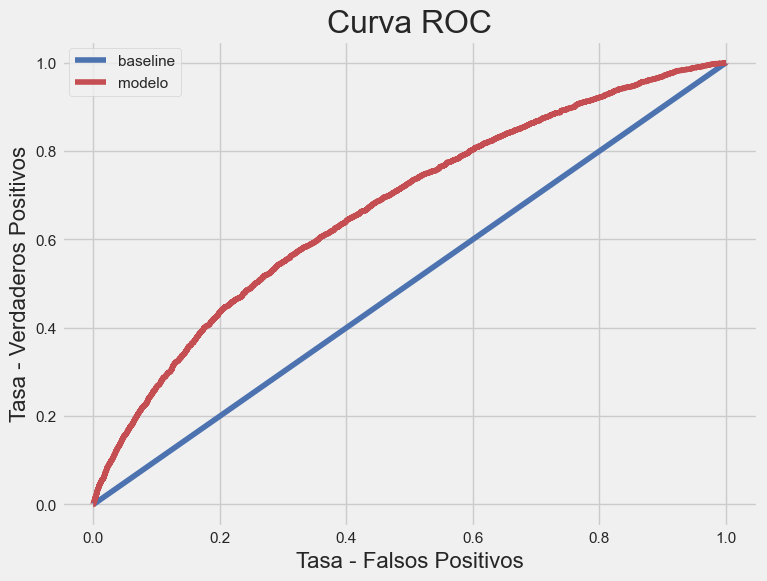

<Figure size 640x480 with 0 Axes>

In [ ]:
evaluate_model(pred, pred_probs, pred_train, pred_probs_train, y1_val, y1_train)
plt.savefig('roc_auc_curve.png')

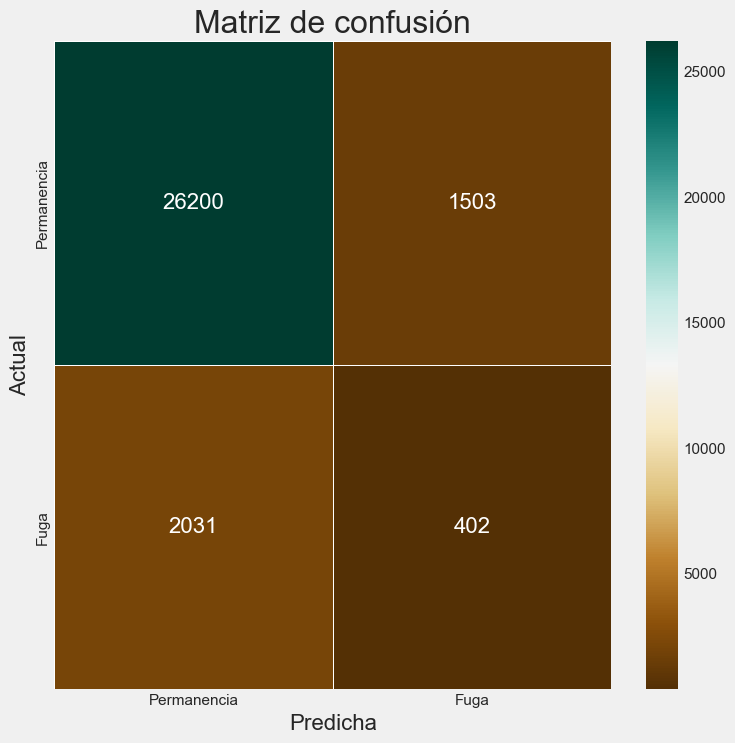

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     27703
           1       0.21      0.17      0.19      2433

    accuracy                           0.88     30136
   macro avg       0.57      0.56      0.56     30136
weighted avg       0.87      0.88      0.88     30136



In [ ]:
mostrar_resultados(y1_val, pred)

## 2da Forma
* Se utiliza LogisticRegression
* Se utilizan los datos cambiando todos los NaNs

In [ ]:
class_weights = {0: 1, 1: 1}

base = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(class_weight=class_weights, random_state=42))
])

param_grid = {
    'clf__C': np.logspace(-5,5,10),
    'clf__solver': ['newton-cholesky', 'sag', 'saga'],
    'clf__max_iter': [100, 200, 300],
}

grid_search = GridSearchCV(base, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 1},
                                                           random_state=42))]),
             param_grid={'clf__C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                         'clf__max_iter': [100, 200, 300],
                         'clf__solver': ['newton-cholesky', 'sag', 'saga']},
             scoring='roc_auc')

In [ ]:
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC Score:", best_auc)

Best Parameters: {'clf__C': 46.41588833612782, 'clf__max_iter': 100, 'clf__solver': 'newton-cholesky'}
Best AUC Score: 0.7480265300603423


In [ ]:
best_model2 = grid_search.best_estimator_


pred = best_model2.predict(X2_val)
pred_probs = best_model2.predict_proba(X2_val)[:,1]

pred_train = best_model2.predict(X2_train)
pred_probs_train = best_model2.predict_proba(X2_train)[:,1]


test_auc = roc_auc_score(y2_val, pred)

print("AUC on Test Set:", test_auc)
if test_auc > mejor_valor:
    mejor_valor = test_auc
    mejor_modelo = best_model2

AUC on Test Set: 0.6872485721075355


Recall Baseline: 1.0 Test: 0.69 Train: 0.68
Precision Baseline: 0.08 Test: 0.16 Train: 0.69
Roc Baseline: 0.5 Test: 0.75 Train: 0.75


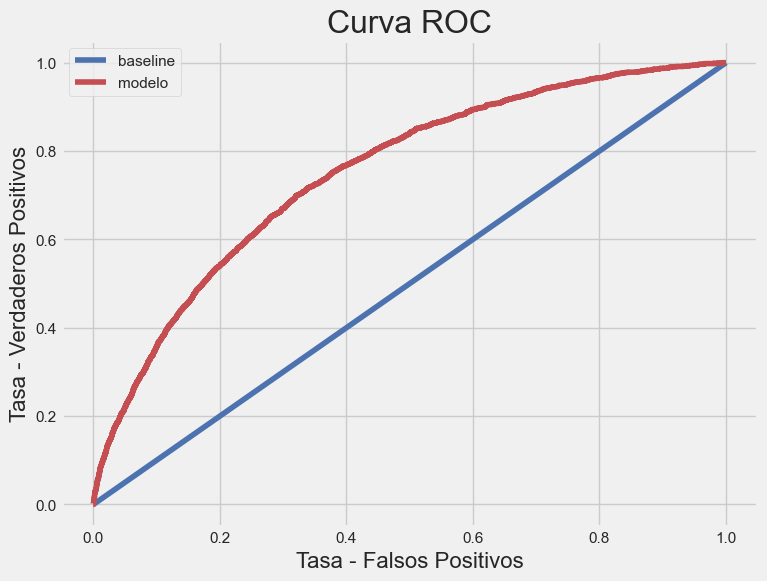

<Figure size 640x480 with 0 Axes>

In [ ]:
evaluate_model(pred, pred_probs, pred_train, pred_probs_train, y2_val, y2_train)
plt.savefig('roc_auc_curve.png')

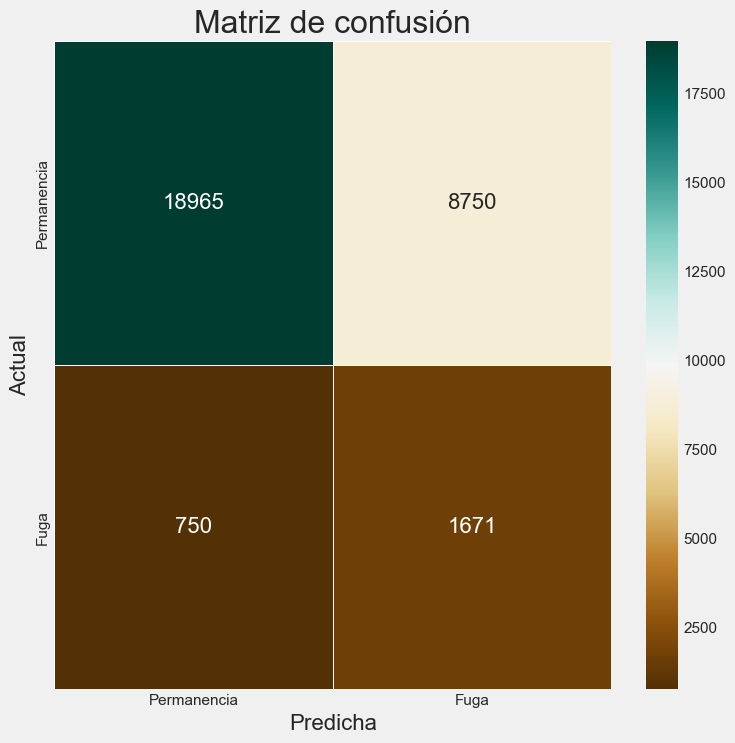

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     27715
           1       0.16      0.69      0.26      2421

    accuracy                           0.68     30136
   macro avg       0.56      0.69      0.53     30136
weighted avg       0.90      0.68      0.76     30136



In [ ]:
mostrar_resultados(y2_val, pred)

## 3ra Forma
* Se utiliza HistGradientBoostingClassifier
* Se utilizan los datos borrando todos los NaNs

In [ ]:
base = Pipeline([
    ('scale', StandardScaler()),
    ('clf', HistGradientBoostingClassifier(random_state=125))
])

param_grid = {
    'clf__learning_rate': np.linspace(0.01,0.9,10),
    'clf__max_iter': [20, 40, 80, 160],
    'clf__max_depth': [3, 4, 5],
    'clf__l2_regularization': [0.0, 0.2, 0.5, 0.9]
}

grid_search = GridSearchCV(base, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        HistGradientBoostingClassifier(random_state=125))]),
             param_grid={'clf__l2_regularization': [0.0, 0.2, 0.5, 0.9],
                         'clf__learning_rate': array([0.01      , 0.10888889, 0.20777778, 0.30666667, 0.40555556,
       0.50444444, 0.60333333, 0.70222222, 0.80111111, 0.9       ]),
                         'clf__max_depth': [3, 4, 5],
                         'clf__max_iter': [20, 40, 80, 160]},
             scoring='roc_auc')

In [ ]:
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC Score:", best_auc)

Best Parameters: {'clf__l2_regularization': 0.9, 'clf__learning_rate': 0.10888888888888888, 'clf__max_depth': 3, 'clf__max_iter': 160}
Best AUC Score: 0.6778295907025136


In [ ]:
best_model3 = grid_search.best_estimator_

pred = best_model3.predict(X1_val)
pred_probs = best_model3.predict_proba(X1_val)[:,1]

pred_train = best_model3.predict(X1_train)
pred_probs_train = best_model3.predict_proba(X1_train)[:,1]

test_auc = roc_auc_score(y1_val, pred)

print("AUC on Test Set:", test_auc)
if test_auc > mejor_valor:
    mejor_valor = test_auc
    mejor_modelo = best_model3

AUC on Test Set: 0.5


Recall Baseline: 1.0 Test: 0.0 Train: 0.0
Precision Baseline: 0.08 Test: 0.0 Train: 0.0
Roc Baseline: 0.5 Test: 0.68 Train: 0.7


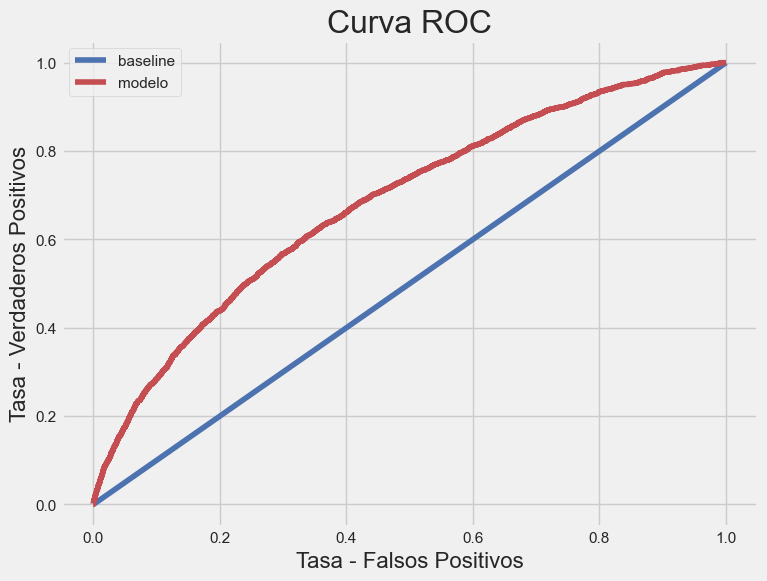

<Figure size 640x480 with 0 Axes>

In [ ]:
evaluate_model(pred, pred_probs, pred_train, pred_probs_train, y1_val, y1_train)
plt.savefig('roc_auc_curve.png')

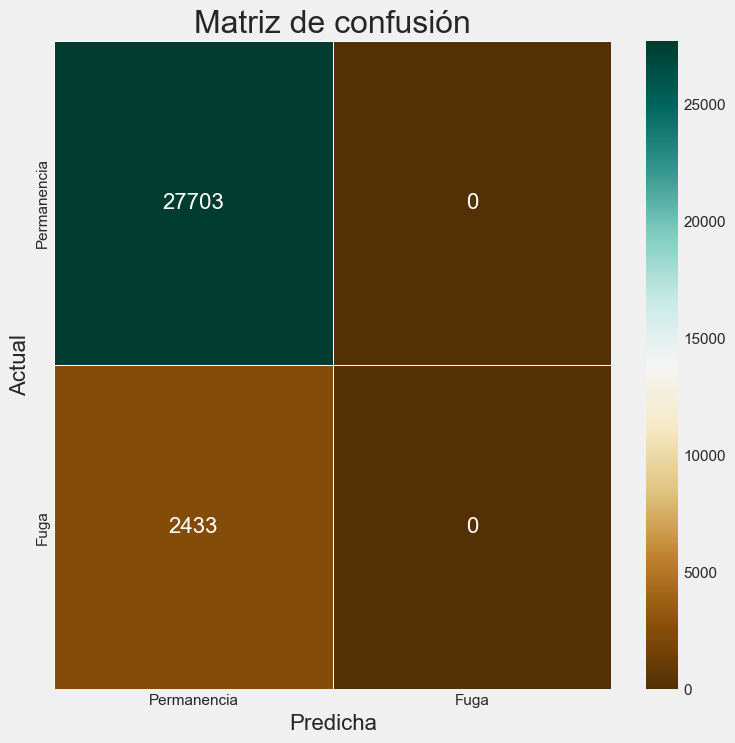

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27703
           1       0.00      0.00      0.00      2433

    accuracy                           0.92     30136
   macro avg       0.46      0.50      0.48     30136
weighted avg       0.85      0.92      0.88     30136



In [ ]:
mostrar_resultados(y1_val, pred)

## 4ta Forma
* Se utiliza HistGradientBoostingClassifier
* Se utilizan los datos cambiando todos los NaNs

In [ ]:
base = Pipeline([
    ('scale', StandardScaler()),
    ('clf', HistGradientBoostingClassifier(random_state=125))
])

param_grid = {
    'clf__learning_rate': np.linspace(0.01,0.9,10),
    'clf__max_iter': [20, 40, 80, 160],
    'clf__max_depth': [3, 4, 5],
    'clf__l2_regularization': [0.0, 0.2, 0.5, 0.9]
}

grid_search = GridSearchCV(base, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        HistGradientBoostingClassifier(random_state=125))]),
             param_grid={'clf__l2_regularization': [0.0, 0.2, 0.5, 0.9],
                         'clf__learning_rate': array([0.01      , 0.10888889, 0.20777778, 0.30666667, 0.40555556,
       0.50444444, 0.60333333, 0.70222222, 0.80111111, 0.9       ]),
                         'clf__max_depth': [3, 4, 5],
                         'clf__max_iter': [20, 40, 80, 160]},
             scoring='roc_auc')

In [ ]:
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC Score:", best_auc)

Best Parameters: {'clf__l2_regularization': 0.5, 'clf__learning_rate': 0.9, 'clf__max_depth': 5, 'clf__max_iter': 160}
Best AUC Score: 0.9066961008875392


In [ ]:
best_model4 = grid_search.best_estimator_

pred = best_model4.predict(X2_val)
pred_probs = best_model4.predict_proba(X2_val)[:,1]

pred_train = best_model4.predict(X2_train)
pred_probs_train = best_model4.predict_proba(X2_train)[:,1]

test_auc = roc_auc_score(y2_val, pred)


print("AUC on Test Set:", test_auc)
if test_auc > mejor_valor:
    mejor_valor = test_auc
    mejor_modelo = best_model4

AUC on Test Set: 0.6281490070905973


Recall Baseline: 1.0 Test: 0.47 Train: 0.93
Precision Baseline: 0.08 Test: 0.16 Train: 0.87
Roc Baseline: 0.5 Test: 0.69 Train: 0.96


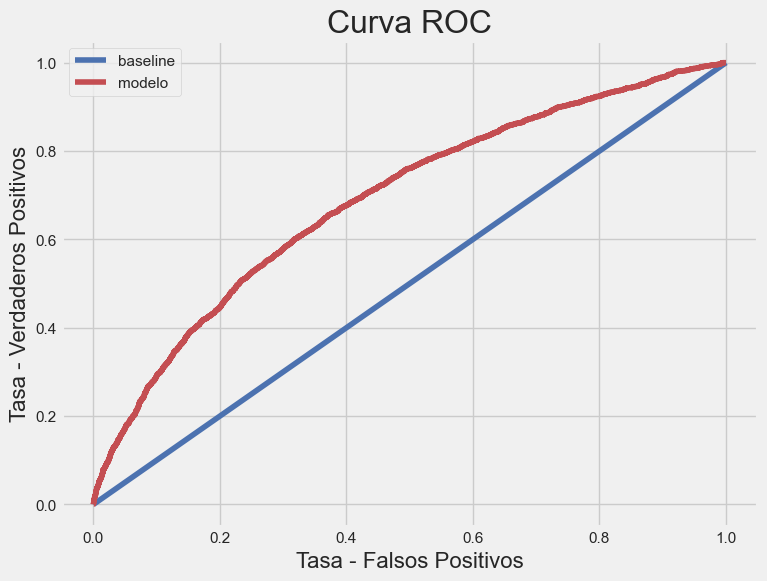

<Figure size 640x480 with 0 Axes>

In [ ]:
evaluate_model(pred, pred_probs, pred_train, pred_probs_train, y2_val, y2_train)
plt.savefig('roc_auc_curve.png')

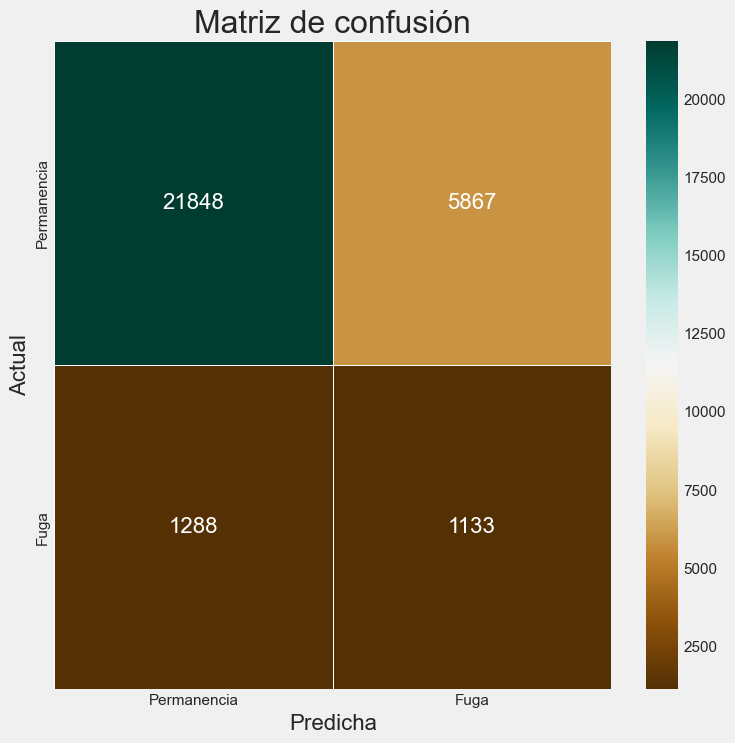

              precision    recall  f1-score   support

           0       0.94      0.79      0.86     27715
           1       0.16      0.47      0.24      2421

    accuracy                           0.76     30136
   macro avg       0.55      0.63      0.55     30136
weighted avg       0.88      0.76      0.81     30136



In [ ]:
mostrar_resultados(y2_val, pred)

## 5ta Forma

* Se le agrega a la 2da forma un PCA en la pipeline

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()

class_weights = {0: 1, 1: 1}

base = Pipeline([
    ('scale', StandardScaler()),
    ('pca', pca),
    ('clf', LogisticRegression(class_weight=class_weights, random_state=42))
])

param_grid = {
    "pca__n_components": [40, 80, 100],
    'clf__C': np.logspace(-5,5,10),
    'clf__solver': ['newton-cholesky', 'sag', 'saga'],
    'clf__max_iter': [100, 200, 300],
}

grid_search = GridSearchCV(base, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X2_train, y2_train)

In [ ]:
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC Score:", best_auc)

In [ ]:
best_model5 = grid_search.best_estimator_

pred = best_model5.predict(X2_val)
pred_probs = best_model5.predict_proba(X2_val)[:,1]

pred_train = best_model5.predict(X2_train)
pred_probs_train = best_model5.predict_proba(X2_train)[:,1]

test_auc = roc_auc_score(y2_val, pred)

print("AUC on Test Set:", test_auc)
if test_auc > mejor_valor:
    mejor_valor = test_auc
    mejor_modelo = best_model5

In [ ]:
evaluate_model(pred, pred_probs, pred_train, pred_probs_train, y2_val, y2_train)
plt.savefig('roc_auc_curve.png')

In [ ]:
mostrar_resultados(y2_val, pred)

## Guardar Mejor Modelo

In [ ]:
dump(mejor_modelo, 'filename.joblib')

NameError: name 'mejor_modelo' is not defined

# Testeo

In [ ]:
clasiffier_model = load('filename.joblib')
#clasiffier_model = best_model4

In [ ]:
clasiffier_model.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler()),
  ('clf',
   LogisticRegression(C=46.41588833612782, class_weight={0: 1, 1: 1},
                      random_state=42, solver='newton-cholesky'))],
 'verbose': False,
 'scale': StandardScaler(),
 'clf': LogisticRegression(C=46.41588833612782, class_weight={0: 1, 1: 1},
                    random_state=42, solver='newton-cholesky'),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'clf__C': 46.41588833612782,
 'clf__class_weight': {0: 1, 1: 1},
 'clf__dual': False,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__l1_ratio': None,
 'clf__max_iter': 100,
 'clf__multi_class': 'auto',
 'clf__n_jobs': None,
 'clf__penalty': 'l2',
 'clf__random_state': 42,
 'clf__solver': 'newton-cholesky',
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'clf__warm_start': False}

In [ ]:
train_median_Respuesta = fill_missing_median(request_test_df.copy())

objectColumns = train_median_Respuesta.select_dtypes(include=['object']).columns.tolist()
objectColumns.remove('WEEKDAY_APPR_PROCESS_START')

order_WEEKDAY_APPR_PROCESS_START = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
train_median_Respuesta['WEEKDAY_APPR_PROCESS_START'] = OrdinalEncoder(categories=[order_WEEKDAY_APPR_PROCESS_START]).fit_transform(train_median_Respuesta[['WEEKDAY_APPR_PROCESS_START']])

encoded_data = ohe_X2.transform(train_median_Respuesta[objectColumns])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=ohe_X2.get_feature_names_out(objectColumns))

train_median_Respuesta = pd.concat([train_median_Respuesta, encoded_df], axis=1)
train_median_Respuesta.drop(columns=objectColumns, inplace=True)



In [ ]:
SK_IDs_column = train_median_Respuesta['SK_ID_CURR'].values
predicciones = clasiffier_model.predict(train_median_Respuesta.drop(columns = ['SK_ID_CURR']))
predicciones

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [ ]:
df = pd.DataFrame(list(zip(SK_IDs_column, predicciones)), columns=['SK_ID_CURR', 'TARGET'])
df

,SK_ID_CURR,TARGET
0,251482,0
1,152322,1
2,213864,0
3,149195,0
4,215443,0
...,...,...
64573,449354,1
64574,118433,0
64575,177671,1
64576,449847,1


In [ ]:
df.to_csv('respuesta.csv', index = False)